# DS 542 Fall 2024 Notebook 4

## Introduction

The goal of this assignment is to give you experience training neural networks and tweaking their architecture.
This notebook loads an image, and builds a neural network implementing a neural field for the image.
That means that the neural network takes in x and y coordinates specifying a pixel in the image, and outputs RGB values for that pixel.
You will modify this notebook and experiment with the neural network to see some of the concepts that we've talked about in class, and get a preview of concepts to come.


## Instructions

1. Change the image URL loaded below so that this notebook loads a different image.
Any image you like is acceptable as long it is appropriate for our school context.
2. Rerun the whole notebook. This should take approximately six minutes for a 256x256 image using a T4 GPU on Google Colab, and proportionately longer for larger images. (You may also run this on the SCC if you prefer.)
3. Pick one of the example neural networks built, and make a copy of the code in the indicated area at the bottom of the notebook.
Modify this code and/or parameters so it produces a visibly different result.
Make sure that the output image of your modified code is saved when you submit this notebook.
4. Answer the questions at the end of this notebook.

In [2]:
!pip install livelossplot --quiet

In [1]:
import functools
import itertools
import math
import os

import imageio.v2 as imageio
import livelossplot
import matplotlib.pyplot as plt
import numpy
import skimage
import torch

ORIGINAL SHAPE (3024, 3024, 3) RANGE 0 255 TYPE uint8


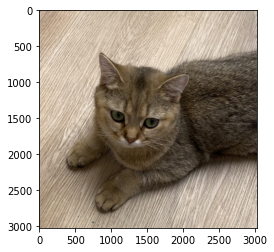

In [2]:
# image_url = "https://www.bu.edu/home/img/masterplate112x50-retina.png"
# image_url = "https://1.gravatar.com/avatar/fa0f0eb94aebd21a885c56792bce38738c6f0a8128bd52ef4ea8f447c9435679?size=256"
image_url = "IMG_9454.jpg"
image_original = imageio.imread(image_url)

print("ORIGINAL SHAPE", image_original.shape, "RANGE", image_original.min().item(), image_original.max().item(), "TYPE", image_original.dtype)

plt.imshow(image_original)

In [3]:
def to_gpu(t):
    if torch.cuda.is_available():
        return t.cuda()
    return t

def to_numpy(t):
    return t.detach().cpu().numpy()

to_gpu(torch.ones(1,1))

tensor([[1.]], device='cuda:0')

IMAGE SHAPE torch.Size([512, 512, 3]) RANGE 6.3000152294989675e-06 0.9888821840286255 TYPE torch.float32


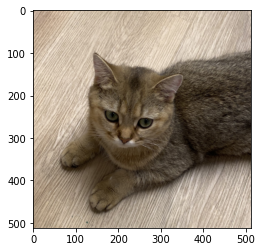

In [4]:
# prepare image for modeling

image = image_original
if image.shape[0] > 512 or image.shape[1] > 512:
    image = skimage.transform.resize(image, (min(image.shape[0], 512), min(image.shape[1], 512)))
if image.shape[0] % 16 or image.shape[1] % 16:
    image = skimage.transform.resize(image, ((image.shape[0] + 15) // 16 * 16, (image.shape[1] + 15) // 16 * 16))
#image = skimage.transform.resize(image, (512, 512))

# remove alpha channel if present
if image.shape[2] == 4:
    image = skimage.color.rgba2rgb(image)

# convert from integer pixel values to float32 and rescale to 0-1 if necessary.
image = torch.tensor(image, dtype=torch.float32)
if image.max() >= 100:
    image = image / 255.0
image = to_gpu(image)

print("IMAGE SHAPE", image.shape, "RANGE", image.min().item(), image.max().item(), "TYPE", image.dtype)
# plot converted image to sanity check
plt.imshow(to_numpy(image))

In [5]:
x = numpy.linspace(-1, 1, image.shape[1], endpoint=True)
y = numpy.linspace(-1, 1, image.shape[0], endpoint=True)

# sample the grid, which will be the input to the model
grid = torch.tensor(numpy.stack(numpy.meshgrid(y, x), -1), dtype=torch.float32)
grid = to_gpu(grid)
print("GRID SHAPE", grid.shape)
X, Y = [grid.view(-1, 2), image.view(-1, 3)]# * 2.0 - 1.0] # skipping renormalization of y to [-1, 1]
print("X Y SHAPES", X.shape, Y.shape)

# train on all pixels
train_X, train_y = [X, Y]

print("TRAIN SHAPES", train_X.shape, train_y.shape)

train_X.requires_grad = False

GRID SHAPE torch.Size([512, 512, 2])
X Y SHAPES torch.Size([262144, 2]) torch.Size([262144, 3])
TRAIN SHAPES torch.Size([262144, 2]) torch.Size([262144, 3])


In [6]:
class NeuralFieldBase(torch.nn.Module):
    def __init__(self,
        input_dimension=2,
        fourier_features=False,
        hidden_layers=4, hidden_width=256,
        output_width=3):
        super().__init__()

        previous_width = input_dimension

        self.fourier_features = fourier_features
        if self.fourier_features:
            self.fourier_dim = 512
            self.fourier_scale = 20.
            self.register_parameter("fourier_b", torch.nn.Parameter(to_gpu(self.fourier_scale * torch.randn(size=(2, self.fourier_dim))), False))
            previous_width = self.fourier_dim * 2

        self.fully_connected_layers = torch.nn.ModuleList()
        self.activation_functions = []

        for layer in range(hidden_layers):
            self.fully_connected_layers.append(to_gpu(torch.nn.Linear(previous_width, hidden_width)))
            previous_width = hidden_width

        self.fully_connected_layers.append(to_gpu(torch.nn.Linear(previous_width, output_width)))

    def forward(self, input):
        x = input
        # print("X device", x.device)

        if self.fourier_features:
            fourier_projection = to_gpu(2 * numpy.pi * x) @ self.fourier_b
            x = torch.cat([torch.sin(fourier_projection), torch.cos(fourier_projection)], dim=-1)

        for (fc, af) in itertools.zip_longest(self.fully_connected_layers,
                                            self.activation_functions):
            # print("X device", x.device, "FC device", fc.weight.device)
            x = fc(x)
            if af:
                x = af(x)

        return x

class SimpleNeuralField(NeuralFieldBase):
    def __init__(self,
        hidden_activation_function=torch.nn.functional.relu,
        output_activation_function=torch.sigmoid,
        **kwargs):
        super().__init__(**kwargs)

        for _ in self.fully_connected_layers[:-1]:
            self.activation_functions.append(hidden_activation_function)

        self.activation_functions.append(output_activation_function)

class ConstantNeuralField(NeuralFieldBase):
    def __init__(self, **kwargs):
        kwargs.update({
            "hidden_layers": 0,
        })

        super().__init__(**kwargs)

        self.register_parameter('a', torch.nn.Parameter(to_gpu(0.5 * torch.ones(1)), True))

    def forward(self, input):
        output_shape = list(input.shape)[:-1] + [self.fully_connected_layers[-1].weight.shape[0]]
        return to_gpu(torch.ones(output_shape)) * self.a

for test_fourier_features in (False, True):
    test_model = ConstantNeuralField(fourier_features=test_fourier_features)
    _ = test_model.forward(to_gpu(torch.Tensor([[0, 0]])))


In [7]:
def mse(gt, pred):
    return 0.5 * torch.mean((gt - pred) ** 2)

def psnr(gt, pred):
    return -10 * torch.log10(2. * torch.mean((gt - pred) ** 2.))

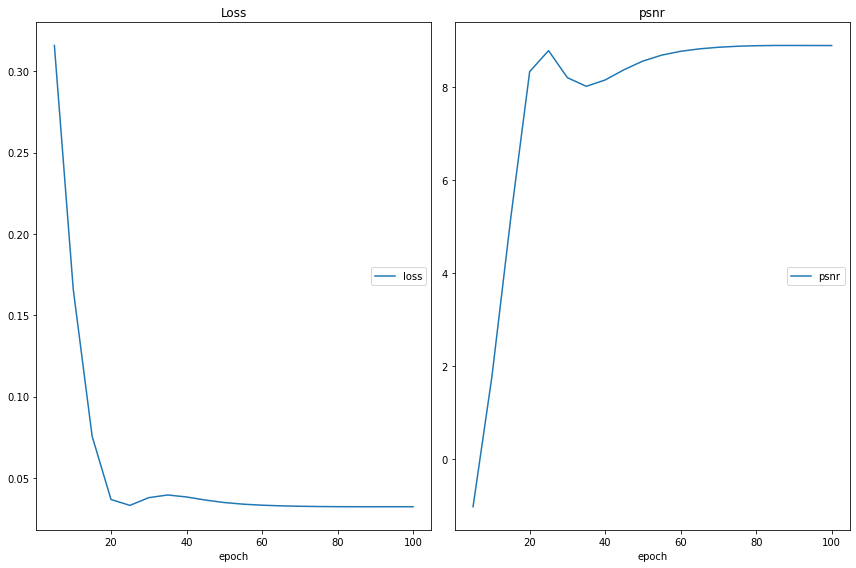

Loss
	loss             	 (min:    0.032, max:    0.316, cur:    0.032)
psnr
	psnr             	 (min:   -1.016, max:    8.891, cur:    8.889)
IMAGE RANGE 6.3000152294989675e-06 0.9888821840286255
PRED RANGE 0.5121195912361145 0.5121195912361145


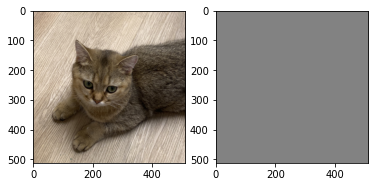

In [8]:
DEFAULT_EPOCHS = 1000 if torch.cuda.is_available() else 100

def train_model(model_class, epochs=DEFAULT_EPOCHS, learning_rate=1e-4, **kwargs):
    model = model_class(**kwargs)
    try:
        model = model.cuda()
    except:
        print("cuda() failed")
    model = torch.nn.DataParallel(model)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    liveloss = livelossplot.PlotLosses()
    #liveloss.to_matplotlib(cell_size=(320, 240))
    for i in range(epochs):
        model.train()
        optimizer.zero_grad(set_to_none=True)
        prediction = model(train_X)
        loss = mse(train_y, prediction)
        loss.backward()
        optimizer.step()

        if (i + 1) % 5 == 0:
            with torch.no_grad():
                model.eval()
                reconstruction = model(X)

            liveloss_updates = {
                'psnr': psnr(train_y, prediction),
                'loss': mse(train_y, prediction),
            }
            liveloss_updates = {k: to_numpy(v) for k, v in liveloss_updates.items()}
            liveloss.update(liveloss_updates,
                            current_step=i+1)
            liveloss.send()

    print("IMAGE RANGE", image.min().item(), image.max().item())

    model.eval()
    pred = to_numpy(model(X)).reshape(*image.shape) #* 0.5 + 0.5
    print("PRED RANGE", pred.min().item(), pred.max().item())

    f, (ax0, ax1) = plt.subplots(1, 2)
    ax0.imshow(to_numpy(image))
    ax1.imshow(pred)

    return model

test_model = train_model(ConstantNeuralField, epochs=100, learning_rate=1.0)

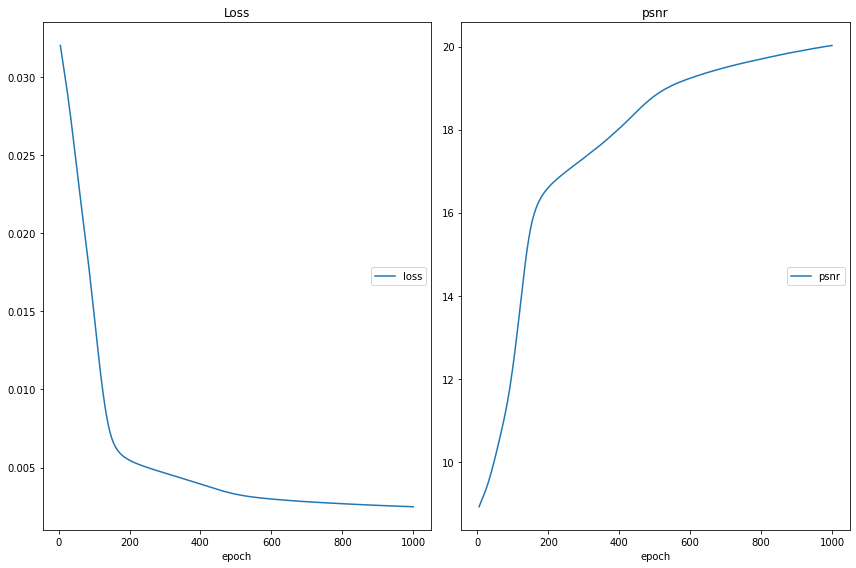

Loss
	loss             	 (min:    0.002, max:    0.032, cur:    0.002)
psnr
	psnr             	 (min:    8.922, max:   20.025, cur:   20.025)
IMAGE RANGE 6.3000152294989675e-06 0.9888821840286255
PRED RANGE 0.06236684322357178 0.8827122449874878


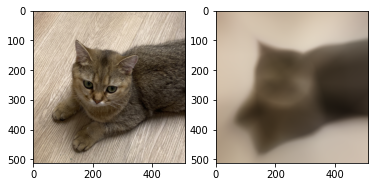

In [9]:
class ReluNeuralField(SimpleNeuralField):
    def __init__(self, **kwargs):
        kwargs.update({
            "hidden_activation_function": torch.nn.functional.relu,
            "output_activation_function": torch.sigmoid,
        })

        super().__init__(**kwargs)

        for layer in self.fully_connected_layers:
            torch.nn.init.xavier_uniform_(layer.weight)
            torch.nn.init.constant_(layer.bias, 0.0)

relu_model = train_model(ReluNeuralField, fourier_features=False)

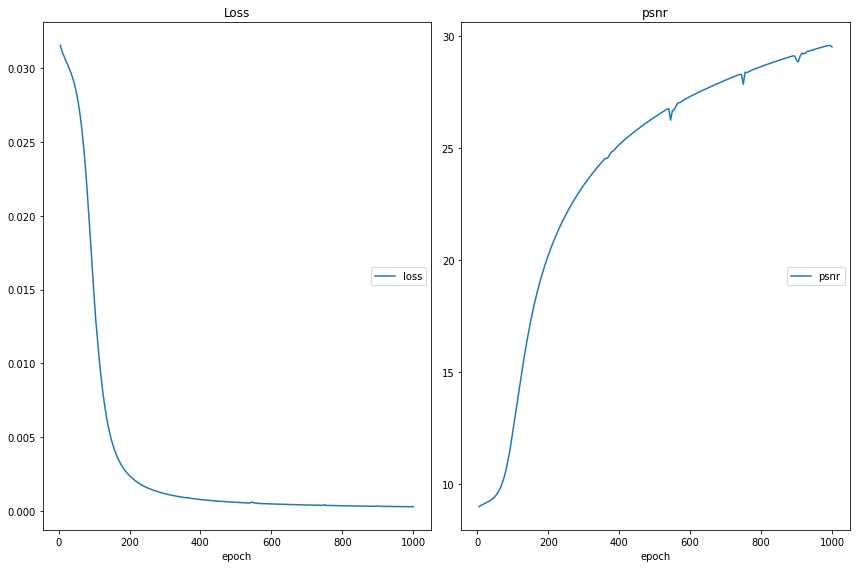

Loss
	loss             	 (min:    0.000, max:    0.032, cur:    0.000)
psnr
	psnr             	 (min:    8.990, max:   29.584, cur:   29.519)
IMAGE RANGE 6.3000152294989675e-06 0.9888821840286255
PRED RANGE 0.007513560354709625 0.9703108668327332


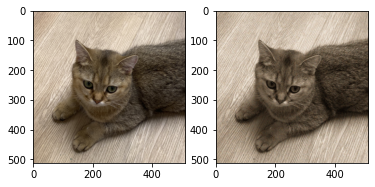

In [10]:
relu_model = train_model(ReluNeuralField, fourier_features=True)

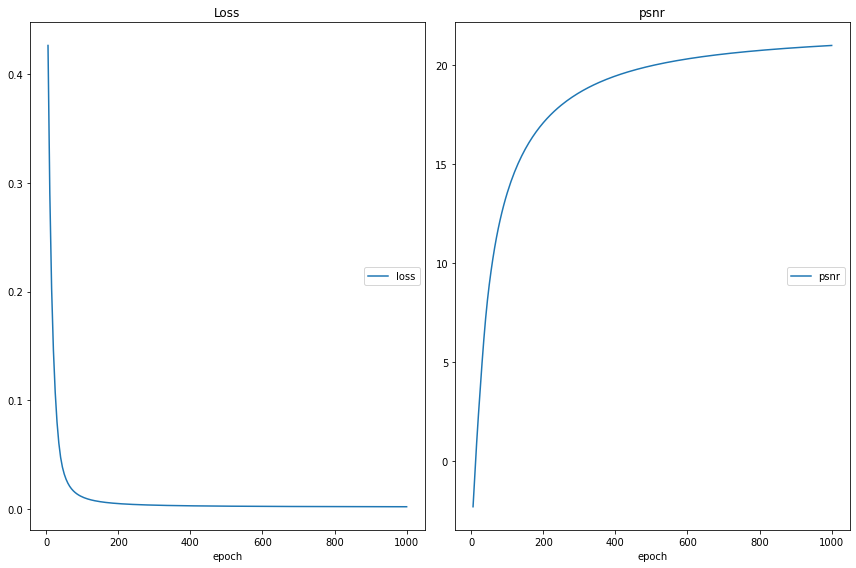

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss
	loss             	 (min:    0.002, max:    0.427, cur:    0.002)
psnr
	psnr             	 (min:   -2.322, max:   21.008, cur:   21.008)
IMAGE RANGE 6.3000152294989675e-06 0.9888821840286255
PRED RANGE -0.03535551577806473 0.9987217783927917


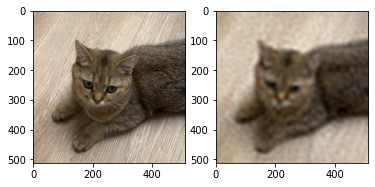

In [11]:
# https://github.com/vsitzmann/siren/blob/master/modules.py#L622

class SirenNeuralField(NeuralFieldBase):
    def __init__(self, omega_0=30.0, **kwargs):
        super().__init__(**kwargs)

        for (i, fc) in enumerate(self.fully_connected_layers):
            previous_width = fc.weight.shape[1]
            if i == 0:
                bound = omega_0 * 1.0 / previous_width
            else:
                bound = math.sqrt(6.0 / previous_width)

            torch.nn.init.uniform_(fc.weight, -bound, +bound)

            if i == 0:
                self.activation_functions.append(torch.sin)
            elif i == len(self.fully_connected_layers) - 1:
                self.activation_functions.append(None) # torch.sigmoid)
            else:
                self.activation_functions.append(torch.sin)

siren_model = train_model(SirenNeuralField, epochs=1001, hidden_width=256)

## Add Your New Neural Network Code and Run It Here


ORIGINAL SHAPE (2923, 2194, 3) RANGE 0 255 TYPE uint8


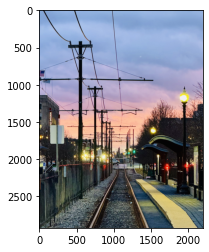

In [12]:
# YOUR CODE HERE
image_url = "IMG_5774.jpg"
image_original = imageio.imread(image_url)

print("ORIGINAL SHAPE", image_original.shape, "RANGE", image_original.min().item(), image_original.max().item(), "TYPE", image_original.dtype)

plt.imshow(image_original)

In [13]:
# Check GPU status
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

0
1
Tesla V100-SXM2-16GB


In [14]:
def to_gpu(t):
    if torch.cuda.is_available():
        return t.cuda()
    return t

def to_numpy(t):
    return t.detach().cpu().numpy()

to_gpu(torch.ones(1,1))

tensor([[1.]], device='cuda:0')

IMAGE SHAPE torch.Size([512, 512, 3]) RANGE 0.0031982401851564646 0.9987713694572449 TYPE torch.float32


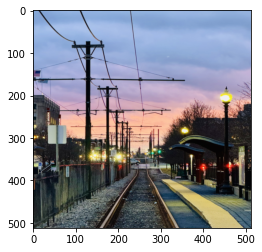

In [15]:
# prepare image for modeling

image = image_original
if image.shape[0] > 512 or image.shape[1] > 512:
    image = skimage.transform.resize(image, (min(image.shape[0], 512), min(image.shape[1], 512)))
if image.shape[0] % 16 or image.shape[1] % 16:
    image = skimage.transform.resize(image, ((image.shape[0] + 15) // 16 * 16, (image.shape[1] + 15) // 16 * 16))
#image = skimage.transform.resize(image, (512, 512))

# remove alpha channel if present
if image.shape[2] == 4:
    image = skimage.color.rgba2rgb(image)

# convert from integer pixel values to float32 and rescale to 0-1 if necessary.
image = torch.tensor(image, dtype=torch.float32)
if image.max() >= 100:
    image = image / 255.0
image = to_gpu(image)

print("IMAGE SHAPE", image.shape, "RANGE", image.min().item(), image.max().item(), "TYPE", image.dtype)
# plot converted image to sanity check
plt.imshow(to_numpy(image))

In [16]:
x = numpy.linspace(-1, 1, image.shape[1], endpoint=True)
y = numpy.linspace(-1, 1, image.shape[0], endpoint=True)

# sample the grid, which will be the input to the model
grid = torch.tensor(numpy.stack(numpy.meshgrid(y, x), -1), dtype=torch.float32)
grid = to_gpu(grid)
print("GRID SHAPE", grid.shape)
X, Y = [grid.view(-1, 2), image.view(-1, 3)]# * 2.0 - 1.0] # skipping renormalization of y to [-1, 1]
print("X Y SHAPES", X.shape, Y.shape)

# train on all pixels
train_X, train_y = [X, Y]

print("TRAIN SHAPES", train_X.shape, train_y.shape)

train_X.requires_grad = False

GRID SHAPE torch.Size([512, 512, 2])
X Y SHAPES torch.Size([262144, 2]) torch.Size([262144, 3])
TRAIN SHAPES torch.Size([262144, 2]) torch.Size([262144, 3])


### The Original Model

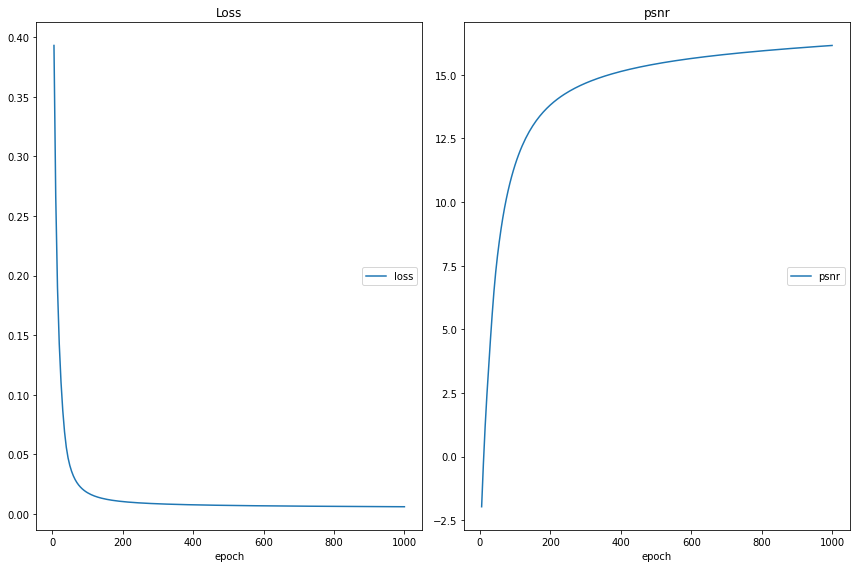

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss
	loss             	 (min:    0.006, max:    0.393, cur:    0.006)
psnr
	psnr             	 (min:   -1.965, max:   16.149, cur:   16.149)
IMAGE RANGE 0.0031982401851564646 0.9987713694572449
PRED RANGE -0.10240791738033295 1.1563738584518433


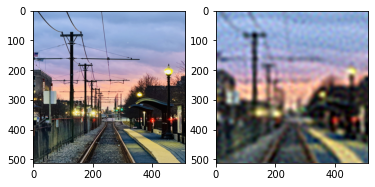

In [17]:
class SirenNeuralField(NeuralFieldBase):
    def __init__(self, omega_0=30.0, **kwargs):
        super().__init__(**kwargs)

        for (i, fc) in enumerate(self.fully_connected_layers):
            previous_width = fc.weight.shape[1]
            if i == 0:
                bound = omega_0 * 1.0 / previous_width
            else:
                bound = math.sqrt(6.0 / previous_width)

            torch.nn.init.uniform_(fc.weight, -bound, +bound)

            if i == 0:
                self.activation_functions.append(torch.sin)
            elif i == len(self.fully_connected_layers) - 1:
                self.activation_functions.append(None) # torch.sigmoid)
            else:
                self.activation_functions.append(torch.sin)

siren_model = train_model(SirenNeuralField, epochs=1001, hidden_width=256)

### Modify the Model by Increasing omega_0

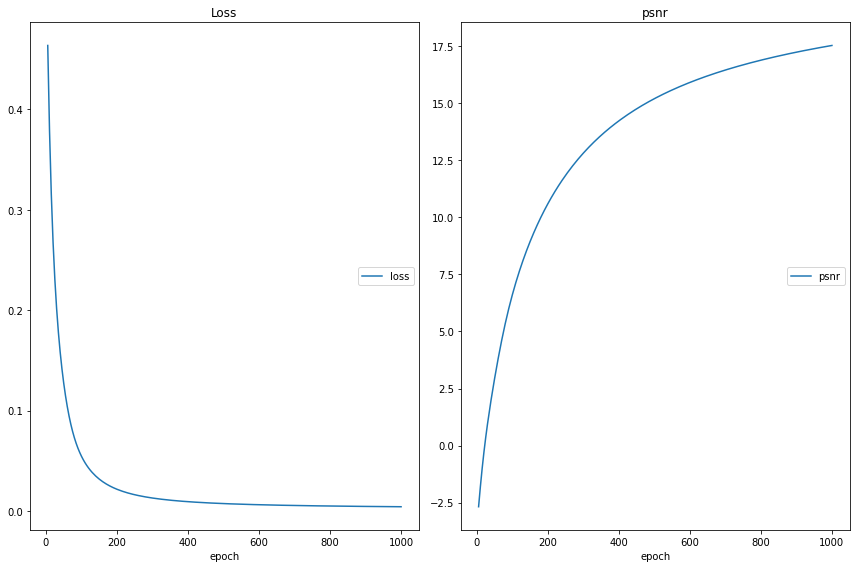

Loss
	loss             	 (min:    0.004, max:    0.463, cur:    0.004)
psnr
	psnr             	 (min:   -2.681, max:   17.535, cur:   17.535)
IMAGE RANGE 0.0031982401851564646 0.9987713694572449
PRED RANGE -0.22472378611564636 1.2397210597991943


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


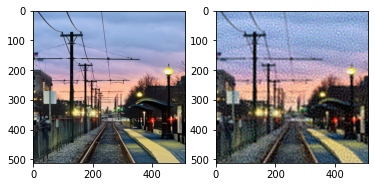

In [18]:
siren_model_1 = train_model(SirenNeuralField, omega_0=90.0, epochs=1001, hidden_width=256)

### Keep Optimizing the Model by Increasing the Number of Layers and Nodes

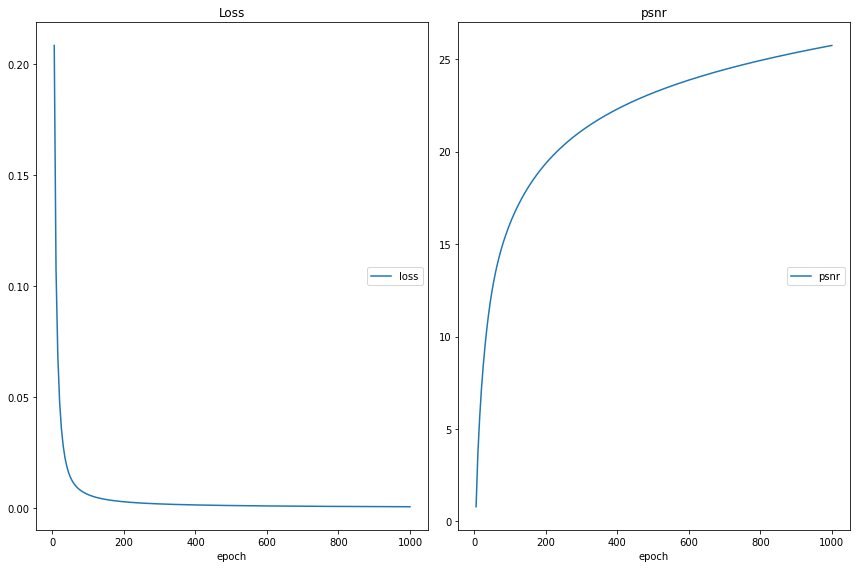

Loss
	loss             	 (min:    0.001, max:    0.208, cur:    0.001)
psnr
	psnr             	 (min:    0.794, max:   25.743, cur:   25.743)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGE RANGE 0.0031982401851564646 0.9987713694572449
PRED RANGE -0.11008614301681519 1.1396703720092773


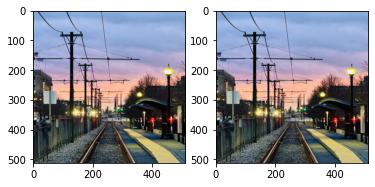

In [19]:
siren_model_2 = train_model(SirenNeuralField, omega_0=90.0, epochs=1001, hidden_layers=12, hidden_width=512)

## Questions

### Question 1

What image did you pick and why?
Do you think it should be easy or hard to model?
Why?

YOUR ANSWER HERE

I selected an image of the BU Central station at sunset, which shows Boston University alongside the MBTA Green Line. The image is visually appealing, with rich colors and a variety of elements like telephone poles, trees, streetlights, and the station platform.

The complexity of the scene, with its combination of natural lighting, man-made structures, and diverse textures, adds significant challenges for the model. These features make it harder to capture all the fine details accurately, which I believe will test the model’s ability to learn and reconstruct the image. The varied lighting and structural components require the model to be highly sensitive to spatial and color variations.

### Question 2

Which example neural network did you choose to modify?
What did you change?
Did you expect any particular visual difference in the output?
What did you actually see?

YOUR ANSWER HERE

I chose to modify the SirenNeuralField network, which I found well-suited to modeling the complexities of my selected image due to its ability to represent high-frequency details via sinusoidal activation functions. This network’s structure is ideal for capturing fine-grained variations in texture and color, which are abundant in the BU Central sunset image.

Initially, I increased the omega_0 parameter. This parameter controls the frequency of the sine activation functions and I believed that by increasing it to 90.0, the model would capture more intricate details in the image. I expected that this adjustment would result in a sharper output, as the network would be better able to model high-frequency components. Indeed, after making this change, the image became clearer, though still not as detailed as the original.

To further enhance the performance, I increased the depth and width of the network by raising the number of hidden_layers to 12 and expanding the hidden_width to 512. This allowed the model to learn the image more thoroughly and produce a more refined output. As expected, the resulting image was a significant improvement over the initial attempt, with greater clarity and detail compared to the original network configuration.